<a href="https://colab.research.google.com/github/ahmedhas32/Data-science-projects/blob/master/predicting_hits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
import math
from scipy import stats

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/open?id=1pjUCoAixcdmnuLcSEscEgUHV7KGGiTU-'


In [ ]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1pjUCoAixcdmnuLcSEscEgUHV7KGGiTU-


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ML Data Scientist Case Study Data.csv')  

### First : we import the data

In [ ]:
data_raw=pd.read_csv('ML Data Scientist Case Study Data.csv' , delimiter=';')

### We run some describtives , we check the structure of data , missing or null values , and how data is stored in each column 

In [ ]:
data_raw.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14
3,988678,L3,Saturday,19,8,2113,51462,6,0,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3


#### we notice that hits column has some missing values coded as '\N' so we can deal with it as target of our prediction

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   row_num            988681 non-null  int64 
 1   locale             988681 non-null  object
 2   day_of_week        988681 non-null  object
 3   hour_of_day        988681 non-null  int64 
 4   agent_id           988681 non-null  int64 
 5   entry_page         988681 non-null  int64 
 6   path_id_set        983792 non-null  object
 7   traffic_type       988681 non-null  int64 
 8   session_durantion  988681 non-null  object
 9   hits               988681 non-null  object
dtypes: int64(5), object(5)
memory usage: 75.4+ MB


#### Let's check percentage of 'hits' values needed to be predicted 

In [ ]:
np.round(len(data_raw.loc[data_raw['hits'] =='\\N'])*100/len(data_raw),2)

37.37

#### we make an indicator to use later in splitting data to dataset to use in building the model and dataset to predict missing hits

In [ ]:
data_raw['predicting']=(data_raw['hits'] !='\\N')*1

In [ ]:
data_raw.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,predicting
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N,0
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14,1
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14,1
3,988678,L3,Saturday,19,8,2113,51462,6,0,1,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3,1


#### for better processing for the data, we transfer path_id_set into a list

In [ ]:
data_raw['path_id_set_new']=data_raw['path_id_set'].astype('str').str.split(';')

In [ ]:
data_raw.head(10)

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,predicting,path_id_set_new
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,\N,0,"[31672, 0]"
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14,1,"[31965, 0]"
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14,1,"[0, 78464]"
3,988678,L3,Saturday,19,8,2113,51462,6,0,1,1,[51462]
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3,1,"[31931, 0]"
5,988676,L3,Monday,1,8,2100,0,1,0,2,1,[0]
6,988675,L2,Friday,20,10,2166,0,1,0,2,1,[0]
7,988674,L3,Sunday,3,1,2113,34302;0,6,2,3,1,"[34302, 0]"
8,988673,L3,Sunday,1,10,2111,34227;0,6,4,3,1,"[34227, 0]"
9,988672,L6,Sunday,5,9,2113,42172;0;38715,2,724,45,1,"[42172, 0, 38715]"


#### We then take the frequencies for several variables that may need to use to predict missing hits



In [ ]:
f=['locale'	,'day_of_week','hour_of_day','agent_id','entry_page','traffic_type','session_durantion']
for i in f :
  print(i)
  print(data_raw[i].value_counts())
  print('  ')
  print('__________________')
  


locale
L3    352454
L6    178430
L2    172904
L4    131271
L5    112054
L1     41568
Name: locale, dtype: int64
  
__________________
day_of_week
Monday       158685
Tuesday      155001
Wednesday    147099
Sunday       144330
Thursday     136476
Friday       127740
Saturday     119350
Name: day_of_week, dtype: int64
  
__________________
hour_of_day
19    64558
20    62676
18    61810
17    55743
21    55437
16    54602
15    54139
14    51718
13    47960
22    44303
12    44062
0     41263
11    39462
23    38038
1     36206
10    34768
2     31961
9     31115
8     27907
3     25421
7     24394
6     21235
4     20638
5     19265
Name: hour_of_day, dtype: int64
  
__________________
agent_id
10    287869
9     194367
1     184228
8      94680
6      59907
2      57077
13     48169
7      26000
14     24743
0       5359
12      3694
11      1986
4        222
5        159
3        121
15       100
Name: agent_id, dtype: int64
  
__________________
entry_page
2113    333163
2116    1959

#### we notice that all categorical variables have limited values to take , or 'like : entry page ' we find that the first 10 or 15 values have the most frequencies 

#### then we make sure that each column is stored in the proper data type

In [ ]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988681 entries, 0 to 988680
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   row_num            988681 non-null  int64 
 1   locale             988681 non-null  object
 2   day_of_week        988681 non-null  object
 3   hour_of_day        988681 non-null  int64 
 4   agent_id           988681 non-null  int64 
 5   entry_page         988681 non-null  int64 
 6   path_id_set        983792 non-null  object
 7   traffic_type       988681 non-null  int64 
 8   session_durantion  988681 non-null  object
 9   hits               988681 non-null  object
 10  predicting         988681 non-null  int64 
 11  path_id_set_new    988681 non-null  object
dtypes: int64(6), object(6)
memory usage: 90.5+ MB




#### we notice that session duration is a numeric column despite it is stored as object 

#### to be able to store it properly, we remove the symbol that replaces missing values'/N' with zero , since this is the most logical value for missing session duration , also it is the mode as clear from frequencies table above 

In [ ]:
data_raw['session_durantion']=data_raw['session_durantion'].str.replace('N','0')

data_raw['session_durantion']=data_raw['session_durantion'].str.replace('\\','0')


In [ ]:
data_raw['session_durantion']=data_raw['session_durantion'].astype('int')

#### doing the similar with hits , anyway our target from the whole case study is ti replace the'\N' then we for now replace missing values in it with zeros to be able to trasfer it into integers till we predict them in the following steps

In [ ]:
data_raw['hits']=data_raw['hits'].str.replace('N','0')

data_raw['hits']=data_raw['hits'].str.replace('\\','0')


In [ ]:
data_raw['hits']=data_raw['hits'].astype('int')

#### on the other hand, 'hour_of_the_day' , 'agent_id','entry_page', and 'traffic_type' despite represented as numeric but their magnitude is string , categorical values , so we represent them as categorical variables.

In [ ]:
data_raw['hour_of_day']=data_raw['hour_of_day'].astype('str')

In [ ]:
data_raw['agent_id']=data_raw['agent_id'].astype('str')

In [ ]:
data_raw['entry_page']=data_raw['entry_page'].astype('str')

In [ ]:
data_raw['traffic_type']=data_raw['traffic_type'].astype('str')

#### one of the characteristics in the data that may help to detect effective factors that affect number of hits visited pages , we take the top 4 visited pages , then make an indicator for each

#### first we detect the top 4 visited pages 

In [ ]:
f=[]
x=data_raw['path_id_set'].astype('str').str.split(';')
for i in x :
    for j in i :
      f.append(j)
    


In [ ]:
x=pd.DataFrame(pd.Series(f).value_counts(), columns=['freq'] )


In [ ]:
x.head()

,freq
0,898419
38715,21011
34741,16019
34812,14971
34390,9277


In [ ]:
x=x.loc[x['freq']>= 1000].head(4)
x.index.name='path_id'

In [ ]:
f=x.loc[x['freq']>= 1000]

In [ ]:
f.index

Index(['0', '38715', '34741', '34812'], dtype='object', name='path_id')

#### then we compute number of visited pages per session

In [ ]:
data_raw['number_of_pages']=len(data_raw['path_id_set_new'])

In [ ]:
v=[]
for i in data_raw['path_id_set_new'].index:
    j=len(data_raw['path_id_set_new'][i])
    v.append(j)

In [ ]:
data_raw['number_of_visited_pages'] = v

#### we compute correlation coeffecient to make sure that numeric variables can help to predict number of hits 

In [ ]:
data_raw.loc[data_raw['predicting']==1,['hits','number_of_visited_pages' ,'session_durantion']].corr()['hits']

hits                       1.000000
number_of_visited_pages    0.403462
session_durantion          0.245583
Name: hits, dtype: float64

#### we notice that 'number_of_visited_pages' has moderate positive correlation with hits , and session_durantion has a weak correlation 

#### then in the following loop , we make a binary column for each of the top 4 visited pages to help to predict hits

In [ ]:
data_raw

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,predicting,path_id_set_new,number_of_pages,number_of_visited_pages
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,0,0,"[31672, 0]",988681,2
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14,1,"[31965, 0]",988681,2
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14,1,"[0, 78464]",988681,2
3,988678,L3,Saturday,19,8,2113,51462,6,0,1,1,[51462],988681,1
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3,1,"[31931, 0]",988681,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988676,5,L2,Tuesday,18,2,2113,44232;0,2,5,0,0,"[44232, 0]",988681,2
988677,4,L6,Tuesday,9,6,2113,38715;0;40057;31657,2,35,0,0,"[38715, 0, 40057, 31657]",988681,4
988678,3,L2,Sunday,17,8,2114,15466;0,6,1011,0,0,"[15466, 0]",988681,2
988679,2,L3,Monday,17,13,2113,531228;0,2,132,0,0,"[531228, 0]",988681,2


In [ ]:

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('hits ~ C(agent_id)', data=data_raw).fit()
anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(agent_id),15.0,9.419820e+06,627987.979284,612.304636,0.0
Residual,988665.0,1.013988e+09,1025.613628,NaN,NaN


In [ ]:
list=x.index.to_list()

In [ ]:
for x1 in x.index :
  innerlist = []
  for i in data_raw['path_id_set_new'].index:
    j1=pd.Series(data_raw['path_id_set_new'][i]).isin([x1]).sum() > 0
    innerlist.append(j1)
  data_raw[x1]=innerlist





In [ ]:
data_raw.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,predicting,path_id_set_new,number_of_pages,number_of_visited_pages,0,38715,34741,34812
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,0,0,"[31672, 0]",988681,2,True,False,False,False
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14,1,"[31965, 0]",988681,2,True,False,False,False
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14,1,"[0, 78464]",988681,2,True,False,False,False
3,988678,L3,Saturday,19,8,2113,51462,6,0,1,1,[51462],988681,1,False,False,False,False
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3,1,"[31931, 0]",988681,2,True,False,False,False


#### then we also we need to make indicator columns for entry pages since they may help in predicting hits , but since we have many pages , we only make an indicator for pages that were entry pages for more than 1000 sessions 

#### First we define a new column that takes 0 if the entry page not one of the pages chosen above 

In [ ]:
data_raw['entry_page1'] = 0 

In [ ]:
data_raw['entry_page']

0         2111
1         2113
2         2100
3         2113
4         2116
          ... 
988676    2113
988677    2113
988678    2114
988679    2113
988680    2116
Name: entry_page, Length: 988681, dtype: object

In [ ]:
f.to_list()

['0', '38715', '34741', '34812']

In [ ]:
f=data_raw['entry_page'].value_counts().head(5).index

In [ ]:
data_raw['entry_page1'] = data_raw['entry_page'].apply(lambda x : x if x in f.to_list() else " ")

In [ ]:
  data_raw['entry_page1'].value_counts()

2113    333163
2116    195904
2100    178912
        122965
2111     83687
2114     74050
Name: entry_page1, dtype: int64

#### then we make dummy variable for each of the columns , entry_page (after modification) , traffic_type , locale , and day of week 

In [ ]:
all_data=pd.get_dummies(data_raw.loc[:,['locale','day_of_week','traffic_type','entry_page1']])

In [ ]:
all_data.head()

,locale_L1,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,traffic_type_1,traffic_type_10,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7,entry_page1_,entry_page1_2100,entry_page1_2111,entry_page1_2113,entry_page1_2114,entry_page1_2116
0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


NameError: ignored

In [ ]:
all_data.count()

locale_L1                988681
locale_L2                988681
locale_L3                988681
locale_L4                988681
locale_L5                988681
locale_L6                988681
day_of_week_Friday       988681
day_of_week_Monday       988681
day_of_week_Saturday     988681
day_of_week_Sunday       988681
day_of_week_Thursday     988681
day_of_week_Tuesday      988681
day_of_week_Wednesday    988681
traffic_type_1           988681
traffic_type_10          988681
traffic_type_2           988681
traffic_type_3           988681
traffic_type_4           988681
traffic_type_6           988681
traffic_type_7           988681
entry_page1_             988681
entry_page1_2100         988681
entry_page1_2111         988681
entry_page1_2113         988681
entry_page1_2114         988681
entry_page1_2116         988681
dtype: int64

In [ ]:
data_raw.count()

row_num                    988681
locale                     988681
day_of_week                988681
hour_of_day                988681
agent_id                   988681
entry_page                 988681
path_id_set                983792
traffic_type               988681
session_durantion          988681
hits                       988681
predicting                 988681
path_id_set_new            988681
number_of_pages            988681
number_of_visited_pages    988681
0                          988681
38715                      988681
34741                      988681
34812                      988681
entry_page1                988681
dtype: int64

#### then we merge the newly generated columns to the data 

In [ ]:
all_data_1=pd.concat([data_raw,all_data],axis=1)

In [ ]:
all_data_1.head()

,row_num,locale,day_of_week,hour_of_day,agent_id,entry_page,path_id_set,traffic_type,session_durantion,hits,predicting,path_id_set_new,number_of_pages,number_of_visited_pages,0,38715,34741,34812,entry_page1,locale_L1,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,traffic_type_1,traffic_type_10,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7,entry_page1_,entry_page1_2100,entry_page1_2111,entry_page1_2113,entry_page1_2114,entry_page1_2116
0,988681,L6,Monday,17,1,2111,31672;0,6,7037,0,0,"[31672, 0]",988681,2,True,False,False,False,2111,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,988680,L2,Thursday,22,10,2113,31965;0,2,49,14,1,"[31965, 0]",988681,2,True,False,False,False,2113,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,988679,L4,Saturday,21,2,2100,0;78464,1,1892,14,1,"[0, 78464]",988681,2,True,False,False,False,2100,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,988678,L3,Saturday,19,8,2113,51462,6,0,1,1,[51462],988681,1,False,False,False,False,2113,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,988677,L2,Tuesday,6,10,2116,31931;0,1,2,3,1,"[31931, 0]",988681,2,True,False,False,False,2116,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_data_1 = pd.read_csv('/content/drive/MyDrive/all_data_1.csv')

In [ ]:
all_data_1=pd.get_dummies(all_data_1 , columns = ['hour_of_day' , 'agent_id'])

#### then we drop columns that were transferred to binary columns and columns that were stored in another type (i.e path_id_set)

#### then we divide the data to training data (the data in which hits is not missing) , and test data (in which hits is missing) also we have an important notice

#### we have columns like day_of_the_week  , locale and traffic_type , if we take all binary variables in analysis we may have collinearity so we exclude the binary column of l'locale_L1','traffic_type_1','entry_page1_0'

In [ ]:
all_data_1=all_data_1.drop(columns=['path_id_set','number_of_pages','locale','day_of_week','traffic_type','entry_page','entry_page1','day_of_week_Friday','locale_L1','traffic_type_1'])

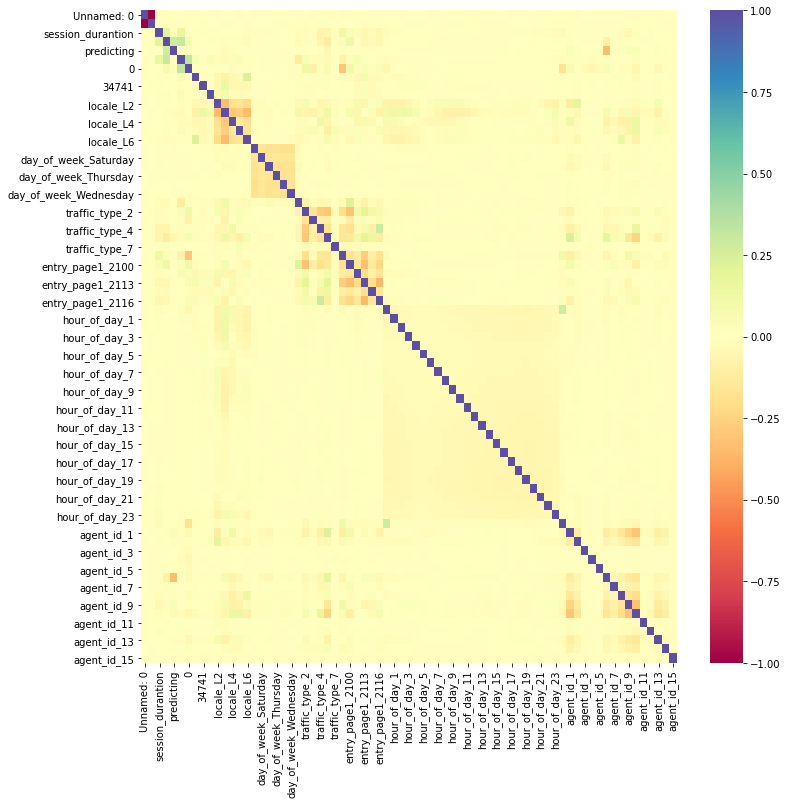

In [ ]:
plt.figure(figsize=(12,12))

sns.heatmap(all_data_1.corr() , center=0 , cmap="Spectral" )

In [ ]:
abs(all_data_1.corr()['hits']).sort_values(ascending=False).head(15).index[1:]

Index(['number_of_visited_pages', 'predicting', 'session_durantion',
       'traffic_type_6', 'entry_page1_2100', 'agent_id_6', '0',
       'traffic_type_4', 'entry_page1_2113', 'entry_page1_2116',
       'entry_page1_ ', 'entry_page1_2114', 'traffic_type_10', 'locale_L5'],
      dtype='object')

In [ ]:
all_data_1.head()

,Unnamed: 0,row_num,session_durantion,hits,predicting,path_id_set_new,number_of_visited_pages,0,38715,34741,34812,locale_L2,locale_L3,locale_L4,locale_L5,locale_L6,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,traffic_type_10,traffic_type_2,traffic_type_3,traffic_type_4,traffic_type_6,traffic_type_7,entry_page1_,entry_page1_2100,entry_page1_2111,entry_page1_2113,entry_page1_2114,entry_page1_2116,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,agent_id_0,agent_id_1,agent_id_2,agent_id_3,agent_id_4,agent_id_5,agent_id_6,agent_id_7,agent_id_8,agent_id_9,agent_id_10,agent_id_11,agent_id_12,agent_id_13,agent_id_14,agent_id_15
0,0,988681,7037,0,0,"['31672', '0']",2,True,False,False,False,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,988680,49,14,1,"['31965', '0']",2,True,False,False,False,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,988679,1892,14,1,"['0', '78464']",2,True,False,False,False,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,988678,0,1,1,['51462'],1,False,False,False,False,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,4,988677,2,3,1,"['31931', '0']",2,True,False,False,False,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
#predictors = ['session_durantion' , 'number_of_visited_pages' ,'0' ,'38715' ,	'traffic_type_6',	'entry_page1_2100' , 'locale_L5' , 'day_of_week_Sunday' , 'hour_of_day_11' ,'agent_id_12']
predictors = abs(all_data_1.corr()['hits']).sort_values(ascending=False).head(15).index[1:]

In [ ]:
train = all_data_1.loc[all_data_1['predicting'] == 1, predictors]

In [ ]:
train=train*1

#### also y_train is available hits , and x test is columns of final data where hits is missing

#### in x test we add row_num to make it the label for the predicted values as demanded in the case study 

In [ ]:
y_train = all_data_1.loc[all_data_1['predicting'] == 1,['hits']]

In [ ]:
x_test = all_data_1.loc[all_data_1['predicting'] == 0,predictors]

In [ ]:
x_test = x_test*1

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
train=scaler.fit_transform(train)
x_test=scaler.fit_transform(x_test)
y_train=scaler.fit_transform(y_train)
                                                   
                                               


### Then we transfer to modelling

#### we use XGB regressor which proved successful and many of winning solutions in kaggle competitions depended on it 

#### we use train test split , meaning that the train set we use also to be divided to train and test datasets , we use the default of 0.75 for training data

#### to have the most satisfactory solution 

#### we got we use cross validation , and grid search to guarntee that the chosen parameters give the best result  

In [ ]:
# Organize our data for training
X = train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y )

In [ ]:
Y

array([[0.01174215],
       [0.00766834],
       [0.00071891],
       ...,
       [0.03187156],
       [0.00455308],
       [0.00023964]])

In [ ]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(n_estimators=100 )
rf.fit(X, Y)

print('Training Accuracy: {:.2f} '.format(rf.score(X, Y)*100))
print('Test Accuracy: {:.2f} '.format(rf.score(X_Val, Y_Val)*100))




Training Accuracy: 72.21 
Test Accuracy: 16.91 


In [ ]:
features = predictors
importances = rf.feature_importances_
indices = np.argsort(importances)

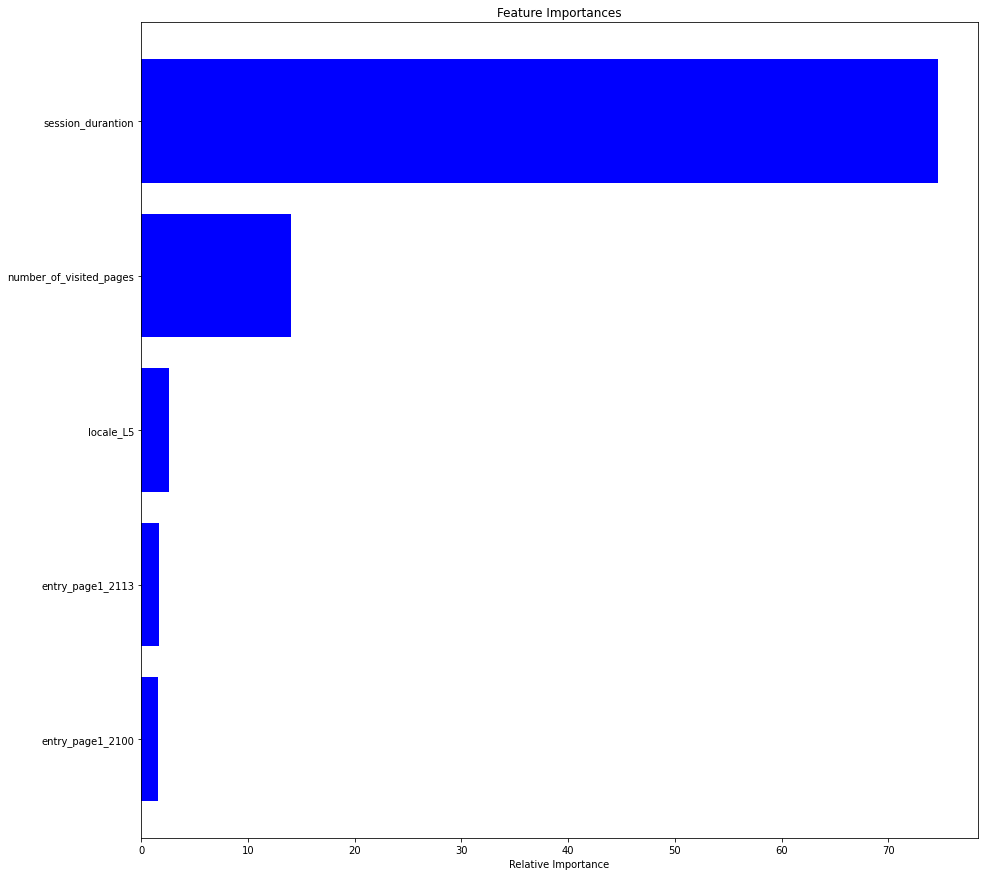

In [ ]:
plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices[-5:])), importances[indices][-5:]*100, color='b', align='center')
plt.yticks(range(len(indices[-5:])), [features[i] for i in indices[-5:]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# A parameter grid for XGBoost
params = {'min_child_weight':[5], 'gamma':[i/10.0 for i in [1]],  'subsample':[i/10.0 for i in [8]],
'colsample_bytree':[i/10.0 for i in [4]] , 'n_estimators' : [500] , 'max_depth' : [10]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1 , objective ='reg:squarederror') 

grid = GridSearchCV(xgb, params)
grid.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid.best_estimator_.predict(X_Val))) 
# Print the r2 score
print(mean_squared_error(Y_Val, grid.best_estimator_.predict(X_Val))) 



0.29750071425913605
6.518640834366767e-05


In [ ]:
grid.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=500,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [ ]:
# Organize our data for training
X = train
Y = y_train
X, X_Val, Y, Y_Val = train_test_split(X, Y)

In [ ]:
X

array([[7.57575758e-03, 0.00000000e+00, 4.52336492e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.57575758e-03, 0.00000000e+00, 3.15127756e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.57575758e-03, 0.00000000e+00, 1.03689442e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 4.17958919e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.57575758e-03, 0.00000000e+00, 1.17143553e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.57575758e-03, 0.00000000e+00, 2.31967432e-05, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:


# A parameter grid for XGBoost
params = {'min_child_weight':[4], 'gamma':[i/10.0 for i in [3]],  'subsample':[i/10.0 for i in range(6)],
'colsample_bytree':[i/10.0 for i in [5]], 'max_depth': [5] ,'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1 ,objective ='reg:squarederror') 

grid1 = GridSearchCV(xgb, params)
grid1.fit(X, Y)

# Print the r2 score
print(r2_score(Y_Val, grid1.best_estimator_.predict(X_Val))) 
# Print the mse score
print(mean_squared_error(Y_Val, grid1.best_estimator_.predict(X_Val))) 

0.2589075617207869
6.876754935220428e-05


#### below the parameters of the best model

In [ ]:
grid1.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.3,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=5, min_child_weight=4, missing=None, n_estimators=100,
             n_jobs=1, nthread=-1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=1)

#### then we apply the best model to the test data(data in which hits is missing) indicating results with row number

In [ ]:
grid2.best_estimator_

### , this seems as clear from E and R2 not so satisfactory result
### But we may have needed more parameter tuning but this is what I could do with computational power of my computer. 


In [ ]:
# Save the file
y_test = np.round(scaler.inverse_transform(grid.best_estimator_.predict(x_test.iloc[:,1:])),0)
results_df = pd.DataFrame(data={'y':y_test} , index=x_test['row_num']) 

In [ ]:
results_df.head()

#### we make row number in a separate column 

In [ ]:
results_df1=pd.DataFrame(results_df.reset_index())

In [ ]:
results_df1.head()

In [ ]:
results_df1.to_csv("hits_predicted.csv", index=False)
